In [22]:
%matplotlib inline
import sys,os,time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.ndimage
from skimage.io import imread, imsave
from skimage.transform import rotate

import torch
from torch.utils.data import Dataset, DataLoader

from utils import LARGE_CHIP_SIZE, CHIP_SIZE, joint_transform
from tqdm import tqdm

from dataloader import AirbusShipPatchDataset, AirbusShipDataset
from streaming_dataloader import StreamingShipDataset
import joblib

import rasterio
import fiona
import shapely.geometry
import cv2
import rasterio.features


In [15]:
train_p_dataset = AirbusShipPatchDataset("./data/train_df.csv", "./data", 
                                         large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform,
                                         rotation_augmentation=True, give_mask_id=True)

In [ ]:
train_p_na_dataset = AirbusShipPatchDataset("./data/train_df.csv", "./data", 
                                         large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform,
                                         rotation_augmentation=False, give_mask_id=True)

In [24]:
ship_areas_by_fn = joblib.load("./data/ship_areas_by_fn.p")

In [25]:
ship_areas_by_fn['b19c65c9f.jpg']

{1: 96, 2: 400, 3: 6079}

## Testing

In [23]:
streaming_dataset = StreamingShipDataset("./data/train_df.csv", "./data", 
                                         large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform,
                                         rotation_augmentation=True, give_mask_id=True, only_ships=True, test=True)

loader = DataLoader(dataset=streaming_dataset, batch_size = 1)

# Get rosetta plots

In [27]:
np.random.seed(42)

# stats
count_masks_with_ships = 0
count_ships_ge70 = 0
count_patches_with_ships = 0

xs = []

for i, (orig, fn, img, mask) in tqdm(enumerate(loader)):
            
    # Check if image has ships
    if mask.sum() > 0:
        num_ships = len(np.unique(mask)) - 1
        
        assert all(x==fn[0] for x in fn)
        
        fn_name = fn[0].split('/')[-1]
        
        curr_ship_area = ship_areas_by_fn[fn_name]
        
        count_masks_with_ships += 1
        
        assert mask.shape == (1,256,256)
        
        temp_patch = np.array(mask[0])
        ships_present = (np.unique(temp_patch))

        # Check if current mask contains > 70% individual ship
        for sp_id in ships_present:
            if sp_id != 0:
                curr_area = (temp_patch == sp_id).sum()

                # Fill as no_ship if < 70% of ship is not in patch
                if (((curr_area / curr_ship_area[sp_id]) < 0.7) and curr_area < 300):
                    temp_patch = (np.where(temp_patch==sp_id, 0, temp_patch))

        ships_present = (np.unique(temp_patch))

        # After successful filtration, more than 1 ship remains
        if(len(ships_present) > 1):
            
            count_ships_ge70 += 1

            # Start counting
#             temp_patch[temp_patch > 0] = 1

            temp_patch = temp_patch.astype(np.uint8)   
            
            assert temp_patch.shape == (256,256)

            shapes = rasterio.features.shapes(temp_patch)
#             polygons = [shapely.geometry.Polygon(s[0]["coordinates"][0]) for s in shapes if s[1] != 0]

            polygons = []
    
            # Filter out tiny artifacts
            for s in shapes:
                polygon_id = (int(s[1]))
                if polygon_id != 0:
                    polygon_area = (shapely.geometry.Polygon(s[0]['coordinates'][0]).area)
                    if ((polygon_area / curr_ship_area[polygon_id] > 0.7) and polygon_area > 300):
                        polygons.append(shapely.geometry.Polygon(s[0]['coordinates'][0]))
            
            if len(polygons) != 0:
                for poly in polygons:
                    rect = poly.minimum_rotated_rectangle

                    points = list(rect.exterior.coords)
                    max_dist = 0
                    max_idx = None

                    temp_xs = []
                    dist_arr = []
                    
                    for i in range(4):
                        dist = distance(points[i], points[i+1])
                        dist_arr.append(dist)
                        if dist >= max_dist:
                            max_dist = dist
                            max_idx = i
                    
                    w,l = (min(dist_arr), max(dist_arr))
                    aspect_ratio = l/w
                    
                    if (aspect_ratio) > 1.2:
                    
                        for i in range(4):
                            dist = distance(points[i], points[i+1])
                            if dist == max_dist:
                                point1 = points[i]
                                point2 = points[i+1]

                                rad = get_angle(point1, point2)
                                xs.append(rad)
                                temp_xs.append(rad)

                            # Plot image for testing

#                                 if rad == 0:
#                                     print(rect.area)
#                                     plt.figure()
#                                     plt.imshow(np.moveaxis(np.array(img[0]), 0, -1))
#                                     plt.show()
#                                     plt.close()

#                                     plt.figure()
#                                     plt.imshow(temp_patch)
#                                     plt.show()
#                                     plt.close()
                    else:
                        pass

#                         print(aspect_ratio)
#                         plt.figure()
#                         plt.imshow(np.moveaxis(np.array(img[0]), 0, -1))
#                         plt.show()
#                         plt.close()

#                         plt.figure()
#                         plt.imshow(temp_patch)
#                         plt.show()
#                         plt.close()
            else:
                pass
                    
                                            

print("Augmented Dataset - {}:\n256x256 Patches with ships: {}\nSuccessfullly filtered ships: {}".format(i, count_masks_with_ships, count_ships_ge70))


275008it [1:00:05, 76.28it/s]

Augmented Dataset - 275007:
256x256 Patches with ships: 65729
Successfullly filtered ships: 56769


In [ ]:
np.unique(xs, return_counts=True)

<ipython-input-28-6371185c6be5>:18: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(b=False, which='minor', axis='x', color='#000', linestyle='-', linewidth=1)


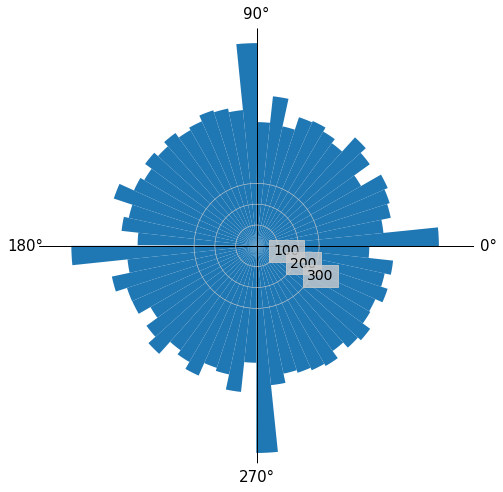

In [28]:
offset=360-36
offset_r = 350
fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw=dict(projection='polar'))

hist, bin_edges, patches = circular_hist(ax, np.array(xs), density=False, bins=60, gaps=True)
#plt.plot([(180+offset)*np.pi/180,offset*np.pi/180], [offset_r,offset_r], color="#ccc", linewidth=0.5, zorder=1)

ax.set_rlabel_position(offset)

plt.yticks([100,200,300], fontsize=14, backgroundcolor="#cccc")
plt.tick_params(axis="y", zorder=3)
plt.xticks([0,np.pi/2,np.pi, 3*np.pi/2], fontsize=15)

#ax.grid(False)


ax.grid(b=True, which='major', axis='x', color='#000', linestyle='-', linewidth=1)
ax.grid(b=False, which='minor', axis='x', color='#000', linestyle='-', linewidth=1)
ax.grid(b=True, which='major', axis='y', color='#ccc', linestyle='-', linewidth=0.6, zorder=0)
ax.grid(b=False, which='minor', axis='y')

ax.spines['polar'].set_visible(False)

plt.show()
plt.close()

### Too slow with normal dataset

In [ ]:
np.random.seed(42)

# stats
count_masks_with_ships = 0
count_ships_ge70 = 0
count_patches_with_ships = 0

xs = []

# Loop
for i, (image, mask, mask_id, fn, res, res_masks) in tqdm(enumerate((train_p_dataset))):
    
#     if i == 10: break
    
    # Check if image has ships
    if mask.sum() > 0:
        num_ships = len(np.unique(mask_id)) - 1
        
        curr_ship_area = ship_areas_by_fn[fn]
        
        count_masks_with_ships += 1
        
        # Iterate over individual 256x256 patches
        idx = 0
        for idx in range(len(res_masks)):
            temp_patch = np.array(res_masks[idx])
            
            # If there are ships in the patch
            if (temp_patch.sum()) > 0:
                ships_present = (np.unique(temp_patch))
                
                count_patches_with_ships += 1
                
                # Check if current mask contains > 70% individual ship
                for sp_id in ships_present:
                    if sp_id != 0:
                        curr_area = (temp_patch == sp_id).sum()
                        
                        # Fill as no_ship if < 70% of ship is not in patch
                        if ((curr_area / curr_ship_area[sp_id]) < 0.7):
                            temp_patch = (np.where(temp_patch==sp_id, 0, temp_patch))
                            

                ships_present = (np.unique(temp_patch))
                if(len(ships_present) > 1):
                    count_ships_ge70 += 1

                    # Start counting
                    temp_patch = temp_patch.astype(np.uint8)                        
                    shapes = rasterio.features.shapes(temp_patch)
                    polygons = [shapely.geometry.Polygon(s[0]["coordinates"][0]) for s in shapes if s[1] != 0]
                    
                    for poly in polygons:
                        sole_polygon = polygons[0]
                        rect = sole_polygon.minimum_rotated_rectangle
                        points = list(rect.exterior.coords)
                        max_dist = 0
                        max_idx = None

                        dist_arr = []
                        for i in range(4):
                            dist = distance(points[i], points[i+1])
                            dist_arr.append(dist)
                            if dist >= max_dist:
                                max_dist = dist
                                max_idx = i


                        for i in range(4):
                            dist = distance(points[i], points[i+1])
                            if dist == max_dist:
                                point1 = points[i]
                                point2 = points[i+1]
                                xs.append(get_angle(point1, point2))
        
                

print(count_masks_with_ships, count_ships_ge70, count_patches_with_ships)
        

7436it [11:06, 10.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

48558it [1:12:37, 11.47it/s]

In [ ]:
polygons = [shapely.geometry.Polygon(s[0]["coordinates"][0]) for s in rasterio.features.shapes(temp_patch) if s[1] != 0]

In [ ]:
plt.imshow(temp_patch)

In [249]:
shapes = rasterio.features.shapes(temp_patch.astype(np.uint8))
g = None
for s in shapes:
    if s[1] != 0:
        g = s
    print(s[1])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0


In [250]:
sole_polygon = polygons[0]
rect = sole_polygon.minimum_rotated_rectangle
points = list(rect.exterior.coords)
max_dist = 0
max_idx = None
radians = []

dist_arr = []
for i in range(4):
    dist = distance(points[i], points[i+1])
    dist_arr.append(dist)
    if dist >= max_dist:
        max_dist = dist
        max_idx = i


for i in range(4):
    dist = distance(points[i], points[i+1])
    if dist == max_dist:
        point1 = points[i]
        point2 = points[i+1]
        radians.append(get_angle(point1, point2))

radians = sorted(radians)

In [251]:
radians

[2.0152155366959956]

In [252]:
points

[(-16.26432532347505, 191.74491682070237),
 (150.4547134935305, 112.35489833641404),
 (168.23659889094267, 149.69685767097965),
 (1.5175600739371475, 229.086876155268),
 (-16.26432532347505, 191.74491682070237)]

In [ ]:
                    
#                     plt.figure()
#                     plt.imshow(np.moveaxis(np.array(res[idx]), 0, -1))
#                     plt.show()
#                     plt.close()

#                     plt.figure()
#                     plt.imshow(temp_patch)
#                     plt.show()
#                     plt.close()

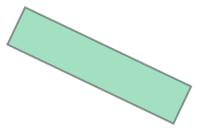

In [253]:
rect

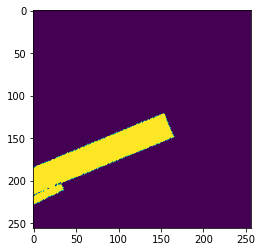

In [254]:
plt.imshow(patch)
shapes = rasterio.features.shapes(np.array(patch).astype('int16'))
polygons = [shapely.geometry.Polygon(s[0]["coordinates"][0]) for s in shapes if s[1] != 0]

# Helper code - run ffirst

In [6]:
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

def get_angle(point1, point2):
    degrees = azimuth(point1, point2)
    return degrees * np.pi / 180

def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches